In [1]:
using Pkg;

In [2]:
using LSHFunctions
using StaticArrays
using DataStructures
using Flux
using MLDatasets
using ImageView
using Plots;

In [3]:
# load full training set
train_x, train_y = MNIST.traindata();
#train_x = permutedims(train_x,[3,2,1])
#train_y = permutedims(train_y,[3,2,1])

In [4]:
train_x = permutedims(train_x,(3,2,1))
x_train = reshape(train_x,(size(train_x)[1],prod(size(train_x)[2:end])));

5


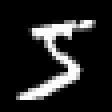

In [5]:
println(train_y[1])
Gray.(train_x[1,:,:])


Possible ideas for improvement of SLIDE/MONGOOSE:
1. Make it compatible with convolutional layers by using a Toeplitz matrix. For some reason the authors have found it difficult (or havent tried) to make SLIDE compatible with CNNs perhaps because their algorithm only directly works as a way to approximate large matrix multiplications and CNN filters are many small matrix multiplications, but it can be made into one large matrix multiplication by generating a circulant matrix. Or make it work with MLP vision models like MLP-Mixer or gMLP.
2. Instead of using a family of (pseudo) random hash functions for LSH, can we use quasi-random hash functions based on low-discrepancy sequences (a la quasi-monte carlo methods) to improve efficiency?
3. Can we combine SLIDE with tensor contraction methods or parameter quantization methods for further performance improvements?
4. Can we combine SLIDE with layer-by-layer training methods (i.e. alternatives to standard backprop such as Equilibrium prop or HSIC bottleneck method)?
5. Instead of generating a hash-table for the current parameter vector $\theta_t$, can we generate a population of parameter vectors and a population of hash-tables to somehow further reduce need for matrix multiplications? E.g., for a linear regression model $f_\theta(x)$ with parameter vector $\theta$, we would need to compute $L(f_\theta(x))$ and then do gradient descent. Can we turn optimization completely into a search problem by hash searching for the parameter vectors (or components thereof) that minimize loss rather than iteratively updating the parameters?
6. Can we combine SLIDE with evolutionary algorithm to further improve efficiency? One idea might be to use a binarized CNN with SLIDE, so SLIDE will use LSH to find the sparse active nodes (or conceptually differently, it does maximum inner product search (MIPS) on the columns of a layer's weight matrix) and then we mutate just this sparse set (in parallel with a population)?
7. SLIDE's LSH mechanism basically adaptively samples a small subset of rows/columns from a layer's weight matrix, making the resulting matrix multiplications much smaller. But each row/column is still dense, what if we enforce some sparsity row/column-wise to make each node attend to a local patch of the input.
8. Maybe for my project, just use a standard CNN like MobileNetv2 pre-trained and then add a few FC layers to do transfer learning using SLIDE.
9. Can we get away with just subsampling the first layer's nodes and using those to decide which nodes to subsample for the subsequent layers?
10. SLIDE will identify a set of active nodes $S$, subsampling a parameter matrix of $n\times m$ (with $n,m$ being large) to $n\times s$, with $s << m$. While this is a significant reduction in FLOPS, if $n$ is large, you're still left with $s$ large vec-vec inner products. Can we do another round of sub-sampling of the vectors to reduce the $n$ dimension? Most simply, we could randomly sample indices from each vector. Or given the assumption that real neurons are locally constrained, we could employ a small sliding window across the vecs to find which group of weights for the node have maximal inner product with which corresponding subset of the input vector.
11. Can we do approximate vec-vec inner products using LSH tables? Can we create two families of LSH functions where if for two vectors $x,y$ the inner product $x\cdot y$ is large and positive then they will hash to the same code with high probability (but not if the inner product is large negative) and a separate family that will hash to same code with high probability if the inner product is large negative? Then we can reduce vec-vec dot products to hash lookups.

##### Background Notes

A hash function is a function $ f : H \rightarrow G$ where $H$ is an infinite set and $G$ is some finite set. In practice, we often take $f : \mathbb{R}^d : G$, where $G$ is a finite subset of the integers or a finite binary vector. Therefore, in the most general case, a hash function maps a continuous space into a finite space. Of course, anything involving a computer is never infinite. But in essence, you can essentially divide up an infinite set into a finite set of "buckets." In some cases, like cryptography, you want a hash function that randomizes the division such that even two points that are very close in the original space $H$ are put in very far buckets in $G$. In locality sensitive hashing, the opposite is true, we want to map two points that are close in $H$ to the same bucket in $G$ with high probability. While LSH is clearly related to dimensionality reduction, it is generally not used for the same purpose. In dimensionality reduction you generally still want to map some infinite space to some other infinite (but lower dimensional) space. For example, random projection (i.e. generating a random matrix to map a high-dimensional vector to a low dimensional vector) is decent dimensionality reduction technique but it is not LSH unless it maps into a discrete space like a binary vector.

The problem where LSH is particularly useful is in approximate nearest neighbor search (ANN), where you have a set of high-dimensional points and you want to find which points are close to a query point. Naively you would have to check all pairwise distances between each point and the query point. With LSH, you compute a hash table of all the points, i.e. you compute the hash $\forall p \in X, m \leftarrow f(p)$ where $X$ is the set of all points, which are assumed to be some high-dimensional real-valued vectors, and $m$ is a dictionary-like data-structure to store each locality-sensitive hash value $f(p)$. Importantly, the points that are sufficiently close in $X$ will be mapped by LSH to the same hash value. Now if you want to find all the points close to some query point $q$ you just compute $f(q)$ and use that as the key in the hash table to find the set of close points, i.e. $m(f(q))$; and it is an $O(1)$ constant-time lookup as it is basically a single random access memory lookup.

In practice, LSH involves not just one locality-sensitive hash function but a family of such functions $F$. One common (but not the most efficient) family of LSH is random projection. If you have some high-dimensional vectors $x \in \mathbb{R}^d$ you can generate random matrices of a particular form and then use an additional threshold function to binarize the randomly projected vector.

Let's explain why you cannot use just one LSH and need a random subset from a family of such functions. Let's assume you have a well-designed LSH function (i.e. one that does a good job keeping two points in the original space in the same) $h : \mathbb{R}^n \rightarrow G$, where $G$ is a finite set such as a short binary vector or finite set of integers. Let's say you want to use it for image search so that you can find which image in a large database $D$ matches a given query image $q$. You can vectorize all the images in $D$, run them through the hash function and save the results in a hashtable $T$, i.e. $\forall d \in D, T \leftarrow h(d)$. Each row of the hash-table has a key (a hash code or value) and a value/store/bucket that contains the set indices of the images in $D$ that were hashed to that same hash code. Now given a query image vector $q$ you just compute $h(q)$ and do an $O(1)$ lookup to find which other images are hashed to the same code (because this ends up just being a RAM address lookup). 

This is fine and useful, but only allows you to find nearly identical images, what if your image search engine wants to return a bunch of image results that are roughly similar and ranked in order of similarity, using LSH and not direct pairwise distance comparisons? This single LSH function $h$ can't do that. However, if you generated a bunch of randomized hash functions $h_l \in \mathcal{F}$ are on average are properly locality sensitive, but any individual two individual hash functions might differ as to how they hash two inputs, so one hash $h_1$ might put vectors $a,b$ in the same bucket whereas hash $h_2$ might put them in different buckets. You can use this variance as means to approximate distance between two vectors $a,b$. If nearly all hash functions $h_l \in \mathcal{F}$ hash $a,b$ into the same buckets, then we can confidently say they are very close. So basically the proportion of hash functions that (or in other words, the probability that two hash functions) put vectors $a,b$ in the same buckets should be monotically related to their distance/similarity in the original space. 

Generally randomized hash functions are very simple and approximate for efficiency, so to improve the accuracy of hashing we can grab $k$ random hash functions $h_k$ and compute $\forall k, h_k(x)$ for some input $x$ and concatenate the resulting hash codes into a longer hashcode. By concatenating together a bunch of simple, low quality hash functions together we can get a more accurate overall hash. 

Now you can do really fast querying of not only identical/near-identical vectors but of any degree of similarity by using $L$ hashtables with $L$ different hash functions. You might wonder why we don't just use one hash-table with $k$ concatenated hash-codes (from different random hash functions), well the answer is efficiency. In order for a hash lookup to be O(1) you have to just give it a full hash key, you can't search the hash table for similar hash keys otherwise that'd be back to at least a linear scan O(n). So if you use multiple hash tables then you can maintain O(1) lookups for each one. 

SLIDE Notes:
- They use uniform sampling of the hash tables to get active nodes to update, i.e. they decide how many active nodes they want to update, $B_l$, and they sample from the hash tables until they reach $B_l$.
- They use SimHash for SLIDE, where a single random hash function from this family takes an input vector $x$ and generates a single bit, i.e. $h(x) = sign(w^T\cdot x), w ~ \mathcal{N}(0,1)$. Alternatively the random unit vector $w$ can be generated by just creating a vector with -1 or +1 with 0.5 probability and apparently this performs similarly. They memoize $w^Tx$ when updating the hash codes (sparse random projection)
- The hash table buckets have a fixed size, so if a full bucket needs to have a node added, they use FIFO
- After each gradient descent they need to update the hash tables, but since this is expensive, they exponentially decay the frequency of updates over training time since empirically most updates happen early on in training. In Mongoose they use a more sophisticated scheduler.
- Given a random subset of the full training data, i.e. a batch $B$, each $x \in B$ is processed separately in a separate thread and each thread does gradient descent on the one input vector and writes the update asynchronously to a global training parameter vector. Since each thread is only updating a small sparse subset of the parameter vector, asynchronous collisions are rare and non-problematic.
- In SLIDE instead of building the hash-table from hashing each node's weight vector, since they use small $k$, they generate all possible hashcodes and build a hash-table using those, then they hash each $w_i$ vector and add the node ID to the corresponding bucket. I'm not sure why this would be faster. Well I guess it moves the overhaed of generating the full hash table to the beginning rather than having additional overheading of creating new hashtable rows during training.
- To ensure the independence of computation across different threads, every neuron stores two additional arrays, each of whose length is equal to the batch size. These arrays keep track of the input specific neuron activations and error gradients. Every input is assigned an id, which can be used as an index to locate its activation (or error gradient) on any neuron. Besides, we also have a bit array at each neuron to determine whether the particular input activates a neuron or not. 
- What do we do if the query does not exist in the hash tables? Two options: 1) Multi-probe LSH, If initial lookup yields totally empty set of nodes, then we random flip some of the bits in the hashcode until we get a successful lookup, _or_ 2) return a random node

Steps:

Assume we have an MLP with two layers, $f_1(x_0;\theta_1),\ f_2(x_1;\theta_2)$ where $\theta_l$ 
are weight matrices and $x_0$ is an input data vector in $\mathbb{R}^n$ and $x_1$ is the output 
vector from $f_1$. To be concrete, $\theta_1 : \mathbb{R}^{n \times m}$ and $\theta_2 : \mathbb{R}^{m\times p}$, 
where $p$ is the output dimension. The first layer function is $x_1 = f_1({x_0}\cdot\theta_1 + t_1)$ where $f_1$ is some non-linear "activation" function and $t_1 : \mathbb{R}^m$ is the bias, i.e. a translation. The second layer is $x_2 = f_2(x_1 \cdot \theta_2 + t_2)$. If $n,m,t$ are large, then this MLP consistents of large, expensive matrix multiplications for inference and training. We will use LSH to sub-sample these large matrices to perform approximate matrix multiplications. Vectors are assumed to be row vectors.

Parameters:        
$b=16$, batch size (set to match cpu cores * 2)     
$n = 784$, input data vector dimension     
$m = 512$, number of layer 1 nodes     
$p = 10$, number of output nodes     
$k = 6$, length of hash codes     
$L = 5$, number of independent hash tables     
$d = 0.1$, proportion of nodes to sample using LSH (e.g. $0.1 * 512 \approx 50$)
$\mu = 0.09$, learning rate

1. Generate the random parameter matrices $\theta_1 : $ and $\theta_2$. These are are dense float matrices.
2. Generate and store $L$ hashtables for each layer $j$, initialized with empty bins by generating all possible hashcodes. This setup can be parallelized.
3. For each layer's weight matrices, hash (using SimHash) each column of the parameter matrix (since each column of $\theta$ represents the weights for an individual node in the graph) using $L$ different random LSH functions $\lambda_l$. Then query the hashtables $h_l$ using the node's hashcode for each node in each hashtable $h_l$ and insert the node ID in the corresponding bin. Some nodes will end up hashing to the same code in a particular hashtable $h_l$. We use Julia's `dict` as the hashmap. This can be parallelized.
4. Sample a random batch of $b$ data vectors and spawn $b$ threads. Load a single input vector for each thread. Hash the input vector using the $\lambda_l$ different LSH functions and then query the corresponding hashtables $h_l$. Each query will return a single bin from each hashtable. Each bin contains the IDs of nodes (matrix columns) in that layer. Compute the union of all queried bins as the sample, $S = \cup \ h_l(\lambda_l(x))$.
5. Sub-sample the columns of $\theta_1$ based on the column IDs in $S$. Perform the small matmul of $x_1 = f_1(x_0 \cdot \theta_1[:,S])$. Let's say $S=20$ in this iteration, then $x_1$ has shape $1\times|S|$ where $|S|$ is the size/length of $S$. But the next layer expects a vector of length $m$. So we generate a zero vector of length $m$, $z_1$ and set the corresponding indices in $S$ to the values in $x_1$.
6. Repeat steps 4-5 for layer 2.
7. Backpropagate using subsampled matrices only.



### Pseudocode SLIDE Algorithm

```
// Begin: Initialization and pre-processing
theta_1 = randn(784,512)
theta_2 = randn(512,10)
layers = [theta_1, theta_2]
for i in 1:L
    // Initialize hash tables
    h_l = init_hash_table(k)
end
// Hash node parameters and add to bins
for layer_j in layers
    // Spawn new thread for each layer
    for node_i, id in cols(layer_j)
        // Hash each column vector L times, add to respective L hashtables
        for hf, l in hash_funs // for each hashfn corresponding to a hashtable
            hash_code_i = hf(node_i)
            // h_l is hashtable[l]
            insert(h_l[hash_code_i], id) // FIFO insert
        end
    end
end
// End pre-processing

// Function to sample active nodes
function 

// Begin: Training loop
for i in 1:epochs
    // Sample batch from training data X
    batch = sample_batch(X,batch_size=b)
    // Spawn b threads, each thread processes a single piece of input data
    threads = spawn(b)
    for t,id in threads
        X = batch[id]
        for layer in layers
            S = sample_nodes(X, h_l, h_f)
            X = layer_fun(X,S)
        // Now we have the active nodes and can sub-sample the parameter matrix
        f_1 = relu(batch[id] * theta_1)
    end
end

```

In [6]:
function comb(n, len) 
    Iterators.product(fill(BitArray([0,1]), len)...) |> collect |> vec 
end

comb (generic function with 1 method)

In [7]:
#Parameters
batch_size = 16
k = 6
L = 5
sample_rate = 0.1 # 1%, proportion of nodes to sample from matrix

0.1

In [8]:
all_hash_codes = comb(1,k); #create all possible hash codes 2^k = 2^6 = 64

In [9]:
# Each layer is associated with `L` hash-tables and therefore `L` hash functions
struct Layer
    theta::Matrix{Float64}
    bias::Vector{Float64}
    hash_funs::Vector{SimHash{Float32}}
    hash_tables::Vector{Dict{Tuple,CircularBuffer{Int64}}}
end

In [10]:
function gen_layer(in_dim,out_dim,k=6,L=6,bin_size=10)
    theta = randn(in_dim,out_dim) / 2
    bias = randn(out_dim) / 5
    cols = size(theta)[2] #number of columns/nodes
    hash_funs = [LSHFunction(cossim, k) for i in 1:L]
    hash_tables = Vector{Dict{Tuple,CircularBuffer{Int64}}}()
    for i in 1:L #create L hash tables
        ht_l::Dict{Tuple,CircularBuffer{Int64}} = Dict{Tuple,CircularBuffer{Int64}}((x) => CircularBuffer{Int64}(bin_size) for x in all_hash_codes)
        push!(hash_tables,ht_l)
        for j in 1:cols
            hash_lj = hash_funs[i](theta[:,j])
            hash_lj = Tuple(hash_lj)
            push!(hash_tables[i][hash_lj],j)
        end
    end
    layer = Layer(theta,bias,hash_funs,hash_tables)
    return layer
end

gen_layer (generic function with 4 methods)

In [11]:
layer1 = gen_layer(784,512)
layer2 = gen_layer(512,10)
layers = [layer1,layer2];

In [12]:
function get_batch(X,batch_size=16)
    indices = rand(1:size(X)[1],batch_size)
    batch = X[indices,:]
    return batch
end

get_batch (generic function with 2 methods)

In [13]:
# hash_funs::Vector{SimHash{Float32}}
# hash_tables::Vector{Dict{Tuple,CircularBuffer{Int64}}}
function sample_nodes(query, layer)
    #`query` is the input vector for this layer
    S = Set{Int64}()
    for i in 1:L
        # compute hash of query using each hashfun
        q_hash = layer.hash_funs[i](query) |> Tuple
        matches = layer.hash_tables[i][q_hash]
        union!(S,matches)
    end
    return S |> collect
end

sample_nodes (generic function with 1 method)

In [14]:
#sample_nodes(vec(train_x[1,:,:]),layer1)

In [15]:
function run_layer(X::Array,layer::Layer, S)
    #S is the subset
    b_size = size(X)[1]
    #println("$(size(X))  $(size(layer.theta[:,S]))  $(size(layer.bias[S]))")
    bias = layer.bias[S]
    bias = reshape(bias, (1,size(bias)[1]))
    bias = repeat(bias,b_size)
    y_ = NNlib.relu.(X * layer.theta[:,S] .+ bias) #16x784 * 784x36 = 16x36
    y = zeros(size(y_)[1],size(layer.bias)[1]) # 16 x 512
    y[:,S] = y_
    return y
end

run_layer (generic function with 1 method)

In [ ]:
X = run_layer(x_train[rand(1:6000,16),:],layers[1],rand(1:512,36))

In [ ]:
run_layer(X,layers[2],1:10)

In [18]:
batch = get_batch(x_train);

In [ ]:
function model(X::Array,layers::Vector{Layer})
    for l in 1:(L-1)
        println("In layer $l")
        S = sample_nodes(X,layers[l])
        X = run_layer(X,layers[l],S)
    end
    return X
end

In [19]:
X = batch
println("Starting...")
for l in 1:(L-1)
    println("In layer $l")
    S = sample_nodes(X,layers[l])
    #X = run_layer(X,layers[l],S)
end

Starting...
In layer 1
In layer 2
In layer 3
In layer 4


In [ ]:
model(batch,layers)

In [ ]:
function train(epochs:Int64)
    for i in 1:epochs
        batch = reshape(get_batch(train_x,batch_size),(batch_size,784))
        X = batch # `X` will be reassigned to most recent layer output
        
        #Flux.train!(Flux.Losses.mse, params(model), data, opt)
    end
end

In [ ]:
batch = get_batch(train_x)

In [ ]:
batch = reshape(batch,(16,784))

In [ ]:
collect(S)

In [ ]:
size(batch * layer1.theta[:,S])